## Dataset generation for GAN to learn NAKAGAMI channels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd

from keras.layers import Dense
from keras.models import Sequential,Model
from scipy.stats import nakagami

from tensorflow.keras.optimizers import Adam


In [2]:
# Variables Initialization

k = 4
M = 2**k
NUM_CHANNEL_USES = 1
block_size = 320

model_training_num_of_frames = 10**3#10**4
model_validating_num_of_frames = 10**2#10**3

n_train = block_size * model_training_num_of_frames
n_val   = block_size * model_validating_num_of_frames

# Geanerating dataset
model_output_num_of_frames = 10**5
n_out = block_size * model_output_num_of_frames 

num_epoches = 5


In [3]:
    
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        
        super(L2Normalization, self).__init__(**kwargs)

    def call(self, inputs):
        out = tf.nn.l2_normalize(inputs, axis=-1)
        print("normalize output shape = ",out.shape)
        return out

    def get_config(self):
        return super(L2Normalization, self).get_config()
    

def generate_nakagami_samples(m, omega):
      
    nakagami_amp_vec = nakagami.rvs(m,omega,size =  NUM_CHANNEL_USES)   # Same gain for the real part and the imaginary part
    nakagami_phase_vec = np.random.uniform(low=0.0, high=2*np.pi, size = NUM_CHANNEL_USES)    # phase shift will effect the complex number
    nakagami_for_real = np.reshape(nakagami_amp_vec*np.cos(nakagami_phase_vec),(-1,1))
    nakagami_for_imag = np.reshape(nakagami_amp_vec*np.sin(nakagami_phase_vec),(-1,1))
    fading_vec = np.reshape(np.concatenate((nakagami_for_real,nakagami_for_imag),axis=1),(1,-1))[0]
    return  tf.constant(fading_vec, dtype=tf.float32)
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=False):
        if  1 or training:
            fading = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"]) 
            return inputs * fading
        
        else:
            return inputs

In [4]:
# Making the stochasticChannelLayer

from scipy.stats import truncnorm
from scipy.stats import uniform

# r = 4           # For upsampling -> number of complex samples per symbol
# roll_off = 0.35 # Roll off factor
# L = 31          # Number of taps (odd) for RRC filter
# f_s = 25e4 # 2e6
# T_bound = 1/f_s # Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
# time_delay = np.random.uniform(-1,1) # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
# CFO = 5e3
# CFO_std = CFO/f_s
# snr = 6
# phase_off = uniform.rvs(scale = 2*np.pi)  # constant for one channel input

channel_parameters = {
    "r"        : 4,             # For upsampling -> number of complex samples per symbol
    "roll_off" : 0.35,          # Roll off factor
    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,          # Add what is in the physical implementation
    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
    "CFO"      : 5e3,           # Observe from the physical implementation
    "CFO_std"  : 5e3/25e4,      # CFO/f_s
    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1 
    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
}

# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# Upsample
def upsampling(inp,r):
  com_reshape = tf.reshape(inp,[-1,1])
  padding = tf.constant([[0,0],[0,r-1]])
  upsampled = tf.pad(com_reshape,padding,"CONSTANT")
  return tf.reshape(upsampled,[-1])

# Normalized RRC with time shift
def NRRC_filter(num_taps, roll_off):
  time_delay =  np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
  print("time_delay - ",time_delay)
  t = np.linspace(-(num_taps-1)/2,(num_taps-1)/2,num_taps) - time_delay
  eps = np.finfo(float).eps # Small epsilon to avoid divisiomn by zero
  pi = np.pi
  def RRC_filter_coff(t):
    if abs(t) < eps:  # For t==0
      return 1.0 - roll_off + (4*roll_off/pi)
    elif roll_off != 0 and (abs(t-1/(4*roll_off))<eps or abs(t+1/(4*roll_off))<eps):
      return (roll_off/np.sqrt(2))*(1 + 2/pi)*np.sin(pi/(4*roll_off)) + (1- 2/pi)*np.cos(pi/(4*roll_off))
    else:
      nu = np.sin(pi*t*(1-roll_off)) + 4*roll_off*t*np.cos(pi*t*(1+roll_off))
      den = pi*t*(1-(4*roll_off*t)**2)
      return nu/(den + eps)
  filter_coff = np.array([RRC_filter_coff(T) for T in t])
  NRRC_filter_coff = filter_coff / np.sum(np.abs(filter_coff))
  plt.stem(t,NRRC_filter_coff)  # Plot for visualization
  return tf.constant(NRRC_filter_coff,dtype = tf.float32)

# Phase offset
def PhaseOffset_vec(batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
  l = batch_size*r*NUM_CHANNEL_USES+num_taps-1
  CFO_off = truncnorm.rvs(-1.96,1.96)*CFO_std  # boundaries will be selected for 95% confidence # 0.1*CFO_std
  print("CFO_off =",CFO_off)   
  print("Phase offset = ",phase_off)                                          # CFO_min and CFO_max (boundaries) will be selected for 95% confidence
  exp_vec = []
  for i in range(l):
    exp_vec.append(tf.math.exp(tf.constant([0+(2*np.pi*i*CFO_off+phase_off)*1j],dtype=tf.complex64)))
  return tf.reshape(tf.stack(exp_vec),[-1])
   

class UpsamplingLayer(keras.layers.Layer):
    def __init__(self, r ):
        super().__init__()
        self.r = r
    def call(self,inputs):
       return upsampling(inputs,self.r)
    
class PulseShaping(keras.layers.Layer): 
    def __init__(self,num_taps,roll_off):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
    def call(self, inputs):
      padding_size = self.num_taps // 2
      paddings = tf.constant([[padding_size, padding_size]])
      real_part = tf.pad(tf.math.real(inputs), paddings, "CONSTANT")
      imag_part = tf.pad(tf.math.imag(inputs), paddings, "CONSTANT")
      real_part = tf.reshape(real_part,[1,-1,1])
      imag_part = tf.reshape(imag_part,[1,-1,1])
      real_conv = tf.nn.conv1d(real_part,self.nrrc_filter,stride=1,padding="SAME")
      imag_conv = tf.nn.conv1d(imag_part,self.nrrc_filter,stride=1,padding="SAME")
      real_conv = tf.reshape(real_conv,[-1])
      imag_conv = tf.reshape(imag_conv,[-1])
      return tf.complex(real_conv,imag_conv)

class PhaseOffset(keras.layers.Layer):
    def __init__(self,batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
      super().__init__()
      self.batch_size = batch_size
      self.num_channel_uses = NUM_CHANNEL_USES
      self.num_taps = num_taps
      self.r = r
      self.CFO_std = CFO_std
      self.phase_off = phase_off
    def call(self,inputs):
       return inputs * PhaseOffset_vec(self.batch_size, self.num_channel_uses,self.num_taps,self.r,self.CFO_std, self.phase_off)

class StochasticChannelLayer(keras.layers.Layer):
    """This channel will output 1D tensor.
        channel_parameters ---> custom class for parameters store
                                channel_parameters = {
                                    "r"        : 4,             # For upsampling -> number of complex samples per symbol
                                    "roll_off" : 0.35,          # Roll off factor
                                    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                                    "f_s"      : 25e4,          # Add what is in the physical implementation
                                    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
                                    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
                                    "CFO"      : 5e3,           # Observe from the physical implementation
                                    "CFO_std"  : 5e3/25e4,      # CFO/f_s
                                    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1 
                                    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }
        r ----------> upsampling constant (number of complex samples per symbol)
        time_delay -> uniformly distributed time delay between (-1,1), discrete domain, 
                      time dilay is giving relative to the sampling period
        CFO_std ----> CFO_frequency / sampling_frequency is taken as the standared deviation
        snr --------> snr for AWGN channel
        output_shape -> None - output_shape is 1D tensor for sequence decoder, or give an output shape prefer """
    def __init__(self,name,NUM_CHANNEL_USES,batch_size,channel_parameters,**kwargs):
        super(StochasticChannelLayer,self).__init__(name=name,**kwargs)
        self.UpSamplingLayer_inst = UpsamplingLayer(channel_parameters['r'])
        self.PulseShaping_inst = PulseShaping(channel_parameters['num_taps'],channel_parameters['roll_off'])
        self.PhaseOffset_inst = PhaseOffset(batch_size,NUM_CHANNEL_USES,channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['CFO_std'],channel_parameters['phase_off'])
        self.AWGNlayer = keras.layers.GaussianNoise(stddev = np.sqrt(1/10**(channel_parameters['snr']/10)))
    def call(self, inputs):
      inputs = tf.reshape(inputs,[-1])
      inputs = real_to_complex_tensor(inputs)
      x = self.UpSamplingLayer_inst(inputs)
      x = self.PulseShaping_inst(x)
      x = self.PhaseOffset_inst(x)
      x = complex_to_real_tensor(x)
      x = self.AWGNlayer(x)
      #print("StochasticChannelLayer output shape = ",x.shape)
      return x
      

In [20]:
"""
# Custom normalizatoion layer

class L2Normalization_Range(tf.keras.layers.Layer):
    def __init__(self,NUM_CHANNEL_USES):
        super().__init__()
        self.num_channel_uses = NUM_CHANNEL_USES
        
    def call(self, inputs):
        arr = []
        s = 0.5
        for i in range(self.num_channel_uses):
        # Expect to scale between 0.5 and 1.5 (first channel uses are closer to 0.5 and last channel uses closer to 1.5)
            s = 0.5 + i*1/(self.num_channel_uses-1)
            arr.append(s)
            arr.append(s)
        a = tf.constant(np.array(arr),dtype=tf.float32)
        out = tf.nn.l2_normalize(inputs, axis=-1)*a
        print("normalize output shape = ",out.shape)
        return out

    def get_config(self):
        return super(L2Normalization, self).get_config()
    """

'\n# Custom normalizatoion layer\n\nclass L2Normalization_Range(tf.keras.layers.Layer):\n    def __init__(self,NUM_CHANNEL_USES):\n        super().__init__()\n        self.num_channel_uses = NUM_CHANNEL_USES\n        \n    def call(self, inputs):\n        arr = []\n        s = 0.5\n        for i in range(self.num_channel_uses):\n        # Expect to scale between 0.5 and 1.5 (first channel uses are closer to 0.5 and last channel uses closer to 1.5)\n            s = 0.5 + i*1/(self.num_channel_uses-1)\n            arr.append(s)\n            arr.append(s)\n        a = tf.constant(np.array(arr),dtype=tf.float32)\n        out = tf.nn.l2_normalize(inputs, axis=-1)*a\n        print("normalize output shape = ",out.shape)\n        return out\n\n    def get_config(self):\n        return super(L2Normalization, self).get_config()\n    '

In [5]:
# Decoder mask layer

class PulseShaping_Dec(keras.layers.Layer): 
    def __init__(self,num_taps,r,roll_off):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off)             # Will add a random time delay, but we will not be using this filter here
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
      self.r =r
    def call(self, inputs):
      inputs = tf.reshape(inputs,[1,-1,1])
      inp_conv = tf.nn.conv1d(inputs,self.nrrc_filter,stride=self.r,padding="VALID")
      inp_conv = tf.reshape(inp_conv,[-1])
      return inp_conv


class DecoderMaskLayer(keras.layers.Layer):
    def __init__(self,name,channel_parameters,NUM_CHANNEL_USES):
        super(DecoderMaskLayer,self).__init__(name=name)
        # self.Convo = PulseShaping_Dec(channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['roll_off'])
        self.Convo = tf.keras.layers.Conv1D(1,channel_parameters['num_taps'],strides=channel_parameters['r'], padding = 'valid',activation = 'relu',use_bias=True)
        self.channel_uses = NUM_CHANNEL_USES
    def call(self,inputs):
        inp = tf.reshape(inputs,[-1,2])
        real_part, imag_part = inp[:,0],inp[:,1]
        vec_shape = real_part.shape[0]
        #print("real shape",real_part.shape)
        real_part, imag_part = tf.reshape(real_part,[1,vec_shape,1]), tf.reshape(imag_part,[1,vec_shape,1])
        real_part = tf.reshape(self.Convo(real_part),[-1,1])
        imag_part = tf.reshape(self.Convo(imag_part),[-1,1])
        #print("real shape after conv ",real_part.shape)
        outputs = tf.concat([real_part,imag_part],1)
        return tf.reshape(outputs,[-1,2*self.channel_uses])


In [7]:
def calc_block_accuracy(preds,y_val):
    n_bits_per_block = preds.shape[1]
    n_correct_bits = np.sum(preds == y_val,axis=1)
    block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
    return block_accuracy


In [8]:
# generating the data set

x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
y_train = x_train

x_val = np.array(np.random.rand(n_val,k)<0.5).astype(np.float32)
y_val = x_val

-------  start ----------
time_delay -  (-0.49952318165663034,)
normalize output shape =  (None, 2)
CFO_off = -0.01803834760391226
Phase offset =  5.345411978138272
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 Encode_last_dense (Dense)   (None, 2)                 34        
                                                                 
 normalization_layer (L2Norm  (None, 2)                0         
 alization)                                                      
                                                                 
 stc (StochasticChannelLayer  (2620,)                  0         
 )                     

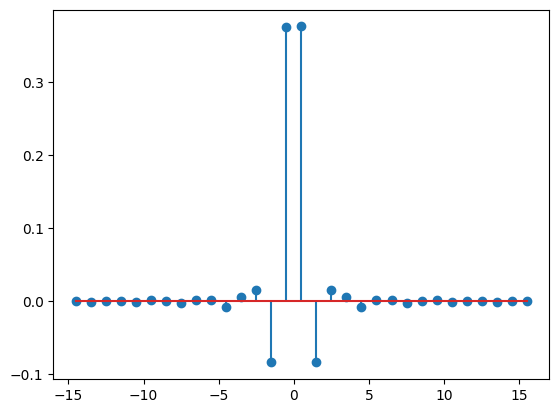

In [10]:
# complete_results = []

nakagami_m = 5 # m=1 foe reighley
OMEGA = np.sqrt(2)
AWGN_std = np.sqrt(1/10**(channel_parameters["snr"]/10))#np.sqrt(OMEGA * 10 ** (-0.1 * gamma_bar) )

act_func = 'tanh' # 'relu'

print(f"-------  start ----------")

def create_AE():
    AE = Sequential([

                    Dense(2**k, activation=act_func,input_shape=(k,)),
                    Dense(2**k, activation=act_func),
                    Dense(2*NUM_CHANNEL_USES, activation='linear',name="Encode_last_dense"),
                    L2Normalization(name="normalization_layer"),
                    #L2Normalization_Range(NUM_CHANNEL_USES),####
                    
                    StochasticChannelLayer("stc",NUM_CHANNEL_USES,block_size,channel_parameters), 
                    #NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
                    #keras.layers.GaussianNoise(stddev = AWGN_std),


                    DecoderMaskLayer("Decoder_mask",channel_parameters,NUM_CHANNEL_USES),

                    Dense(2**k, activation=act_func,name="decoder_start"),
                    Dense(2**k, activation=act_func,name="decoder_middle"),
                    Dense(k, activation='sigmoid')

                    ])
    return AE

AE = create_AE()

AE.summary()


In [11]:
history = []

AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val)))
AE.compile(optimizer=Adam(learning_rate=1e-3),loss="binary_crossentropy")
history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val)))

preds = AE.predict(x_val,batch_size=block_size)>0.5
#         accuracy = np.mean( preds == y_val  )
accuracy =  calc_block_accuracy(preds,y_val)
print(f"validation accuracy = {accuracy}")
print(f"snr = {channel_parameters['snr']}")

Epoch 1/5
normalize output shape =  (320, 2)
CFO_off = -0.018083861940866107
Phase offset =  5.345411978138272
normalize output shape =  (320, 2)
CFO_off = -0.0031477947034706326
Phase offset =  5.345411978138272
normalize output shape =  (320, 2)
CFO_off = 0.0015658732074063197
Phase offset =  5.345411978138272
1000/1000 - 7s - loss: 0.6915 - val_loss: 0.6905 - 7s/epoch - 7ms/step
Epoch 2/5
1000/1000 - 2s - loss: 0.6909 - val_loss: 0.6881 - 2s/epoch - 2ms/step
Epoch 3/5
1000/1000 - 2s - loss: 0.6908 - val_loss: 0.6885 - 2s/epoch - 2ms/step
Epoch 4/5
1000/1000 - 2s - loss: 0.6909 - val_loss: 0.6890 - 2s/epoch - 2ms/step
Epoch 5/5
1000/1000 - 2s - loss: 0.6904 - val_loss: 0.6879 - 2s/epoch - 2ms/step
Epoch 1/5
normalize output shape =  (320, 2)
CFO_off = -0.024981272302222926
Phase offset =  5.345411978138272
normalize output shape =  (320, 2)
CFO_off = -0.015110161804892082
Phase offset =  5.345411978138272
normalize output shape =  (320, 2)
CFO_off = -0.0017011810338559568
Phase offse

[[1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 1. 1.]]
normalize output shape =  (320, 2)
1/1 [==============================] - 0s 50ms/step


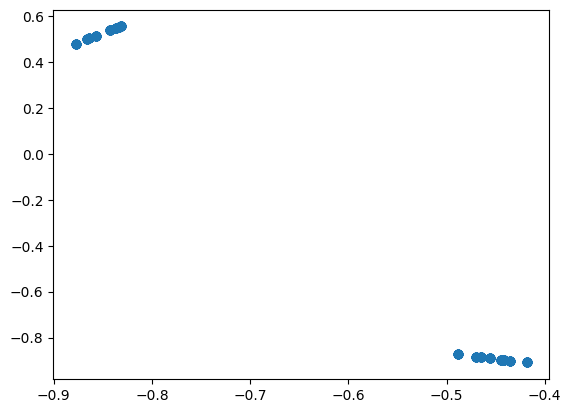

In [12]:
before_channel = Model(inputs=AE.input,
                                 outputs=AE.get_layer('normalization_layer').output)
x = np.array(np.random.rand(block_size,k)>0.5).astype(np.float32)
print(x)
enc=tf.reshape(before_channel.predict(tf.constant(x),batch_size=block_size),[-1,2])
enc_x,enc_y = tf.reshape(enc[:,0],[-1]),tf.reshape(enc[:,1],[-1])
plt.scatter(enc_x,enc_y)

In [13]:
x = np.array(np.random.rand(block_size,k)>0.5).astype(np.float32)
print(x)
print(AE.predict(tf.constant(x),batch_size=block_size)>0.5)

[[0. 1. 1. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 1.]
 ...
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
1/1 [==============================] - 0s 20ms/step
[[False  True False False]
 [False  True False False]
 [False  True False False]
 ...
 [False  True False False]
 [False  True False False]
 [False  True False False]]


### Saving model Encoder and decoder
https://www.tensorflow.org/tutorials/keras/save_and_load

In [22]:
# Save the weights
AE.save_weights('./AE_model')

### Ploting 

In [14]:
history[0].history.keys()

dict_keys(['loss', 'val_loss'])

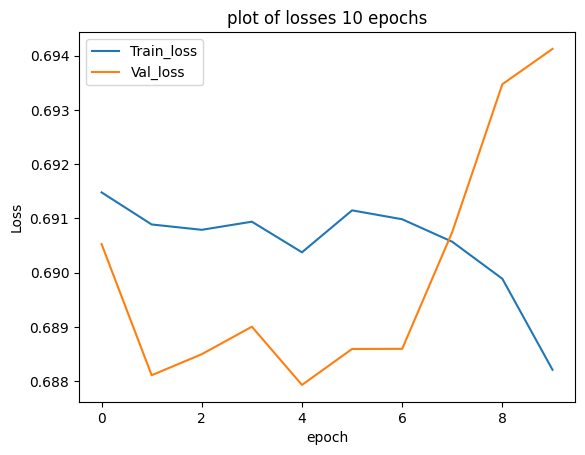

In [15]:
plt.plot(history[0].history['loss']+history[1].history['loss'])
plt.plot(history[0].history['val_loss']+history[1].history['val_loss'])
plt.title('plot of losses '+str(num_epoches*2)+' epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train_loss', 'Val_loss'])
plt.show()

## Apply Nakagami effect and generate dataset

Need the encodings we present to the channel (i.e "before_channel")


In [16]:
AE_best = AE # not comparing.. we got only one

before_channel = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('normalization_layer').output)

# not used
after_channel = Model(inputs=AE_best.get_layer("decoder_start").input,
                                 outputs=AE_best.output)



In [17]:
def nakagami_channel_without_awgn(m, omega, num_samples):
    nakagami_var =  nakagami.rvs(m,omega,size = num_samples)
    nakagami_phase_vec = np.exp(1j*np.random.uniform(low=0.0, high=2*np.pi, size = num_samples))
    # Generate channel with noise
    channel = nakagami_var*nakagami_phase_vec
    return channel

def nakagami_channel_with_awgn(m, omega, snr_db, num_samples):
    nakagami_var =  nakagami.rvs(m,omega,size = num_samples)
    nakagami_phase_vec = np.exp(1j*np.random.uniform(low=0.0, high=2*np.pi, size = num_samples))
    noise_var = 10**(-snr_db/10)
    # Genarating random noise
    noise = np.random.normal(scale=np.sqrt(noise_var), size=num_samples)
    # Generate channel with noise
    channel = noise + nakagami_var*nakagami_phase_vec
    return channel
    

In [ ]:
print(np.exp(np.pi/4*1j))

(0.7071067811865476+0.7071067811865476j)


In [18]:
# Creating and Adding the dataset to a csv

def add_to_csv(n_out):
    
    ##
    x_out = np.array(np.random.rand(n_out,k)<0.5).astype(np.float32)

    ##
    # get encodings given by DNN for each message in training set
    enc = before_channel(x_out)
    #print('enc.shape: ', enc.shape)

    # convert to iq_samples
    iq_samples = tf.complex(enc[:,0::2], enc[:,1::2])
    #print('iq_samples.shape: ', iq_samples.shape)

    ##
    M_POOL       = [1,1.25,1.5,1.75,2]
    OMEGA_POOL = [1.2,np.sqrt(2),1.6]
    SNR_DB_POOL  = [5.5,6,6.5]

    nakagami_chanel_coeff_tensor = []

    block_size = 320
    n_blocks = enc.shape[0] // block_size 
    for i in range(n_blocks):
        m = np.random.choice(M_POOL)
        snr_db = np.random.choice(SNR_DB_POOL)
        omega = np.random.choice(OMEGA_POOL)
        nakagami_chanel_coeff_tensor.append( nakagami_channel_with_awgn(m=m, omega=1,snr_db=snr_db, num_samples=(block_size,iq_samples.shape[1])) )

    nakagami_chanel_coeff_tensor = tf.constant(nakagami_chanel_coeff_tensor)
    #print("nakagami_chanel_coeff_tensor.shape : ",nakagami_chanel_coeff_tensor.shape)

    iq_samples_blocked = np.reshape(iq_samples,(n_blocks,block_size,-1))
    #print("iq_samples_blocked.shape : ",iq_samples_blocked.shape)


    # tested identity flow (enc == received_enc)  with : nakagami_chanel_coeff_tensor =  tf.complex(1.,0.)

    # element wise multiply
    nakagami_affected_iq_samples = tf.multiply(nakagami_chanel_coeff_tensor,iq_samples_blocked)
    # undo the blockking
    nakagami_affected_iq_samples = tf.reshape(nakagami_affected_iq_samples,(block_size*n_blocks,-1))
    #print("nakagami_affected_iq_samples.shape : ",nakagami_affected_iq_samples.shape)

    ##
    # need to convert each iq_samples to two encoding
    real_part =  tf.expand_dims(tf.math.real(nakagami_affected_iq_samples),axis=2)
    imag_part =  tf.expand_dims(tf.math.imag(nakagami_affected_iq_samples),axis=2)

    concat = tf.concat((real_part,imag_part),axis=2)
    #print("concat.shape : ",concat.shape)
    received_enc = tf.cast(tf.reshape(concat,(block_size*n_blocks,-1)),tf.float32)
    #print("received_enc.shape : ",received_enc.shape)

    ## 
    #Summary
    # enc is the encodings presenet to channel  
    # messages --> bits --> [trained DNN]  --> enc 
    #print('enc.shape: ', enc.shape)


    # received_enc is the encoding equavalent after Nakagami+noise effects considered
    # enc --> iq_samples --> [NAKAGAMI+noise effect]  --> affected_iq_smaples --> received_enc
    #print('received_enc.shape: ', received_enc.shape)

    # see the difference done by the channel
    enc - received_enc

    ##
    ## Adding to csv file
    enc = np.reshape(enc,(-1,1))
    received_enc = np.reshape(received_enc,(-1,1))
    #print(enc.shape)
    data = np.concatenate((enc,received_enc),axis=1)
   #print(data.shape)
    df = pd.DataFrame(data)  
    df.to_csv("my_data_.csv", mode = 'a',index=False, header=False) 


In [ ]:
for i in range(int(n_out//100*block_size)):
    add_to_csv(100*block_size)

iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)
iq_samples.shape:  (32000, 7)


KeyboardInterrupt: 

### Loading model

time_delay -  (-0.6678842868476162,)
normalize output shape =  (None, 2)
CFO_off = -0.0009350862165893193
Phase offset =  5.345411978138272


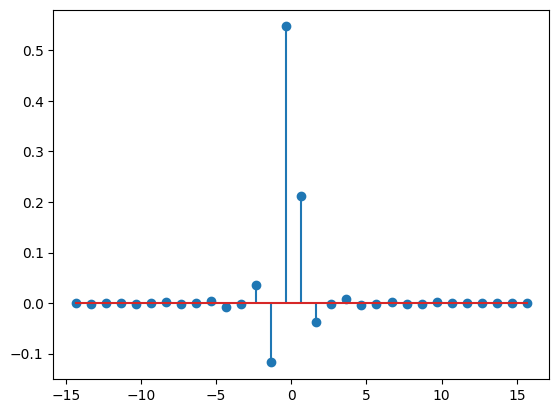

In [23]:
AE_load = create_AE()
AE_load.load_weights('./AE_model')

before_channel = Model(inputs=AE_load.input,
                                 outputs=AE_load.get_layer('normalization_layer').output)

# not used
after_channel = Model(inputs=AE_load.get_layer("decoder_start").input,
                                 outputs=AE_load.output)

In [20]:
 ##
n_out = 2
block_size=1
x_out = np.array(np.random.rand(n_out,k)<0.5).astype(np.float32)

##
# get encodings given by DNN for each message in training set
enc = before_channel(x_out)
#print('enc.shape: ', enc.shape)

# convert to iq_samples
iq_samples = tf.complex(enc[:,0::2], enc[:,1::2])
#print('iq_samples.shape: ', iq_samples.shape)

##
M_POOL       = [0.5,1,1.5]
SNR_DB_POOL  = [1,3,6]

nakagami_chanel_coeff_tensor = []

n_blocks = enc.shape[0] // block_size 
for i in range(n_blocks):
    m = np.random.choice(M_POOL)
    snr_db = np.random.choice(SNR_DB_POOL)
    nakagami_chanel_coeff_tensor.append( nakagami_channel_with_awgn(m=m, omega=1,snr_db=snr_db, num_samples=(block_size,iq_samples.shape[1])) )

nakagami_chanel_coeff_tensor = tf.constant(nakagami_chanel_coeff_tensor)
#print("nakagami_chanel_coeff_tensor.shape : ",nakagami_chanel_coeff_tensor.shape)

iq_samples_blocked = np.reshape(iq_samples,(n_blocks,block_size,-1))
#print("iq_samples_blocked.shape : ",iq_samples_blocked.shape)


# tested identity flow (enc == received_enc)  with : nakagami_chanel_coeff_tensor =  tf.complex(1.,0.)

# element wise multiply
nakagami_affected_iq_samples = tf.multiply(nakagami_chanel_coeff_tensor,iq_samples_blocked)
# undo the blockking
nakagami_affected_iq_samples = tf.reshape(nakagami_affected_iq_samples,(block_size*n_blocks,-1))
#print("nakagami_affected_iq_samples.shape : ",nakagami_affected_iq_samples.shape)

##
# need to convert each iq_samples to two encoding
real_part =  tf.expand_dims(tf.math.real(nakagami_affected_iq_samples),axis=2)
imag_part =  tf.expand_dims(tf.math.imag(nakagami_affected_iq_samples),axis=2)

concat = tf.concat((real_part,imag_part),axis=2)
#print("concat.shape : ",concat.shape)
received_enc = tf.cast(tf.reshape(concat,(block_size*n_blocks,-1)),tf.float32)
#print("received_enc.shape : ",received_enc.shape)

## 
#Summary
# enc is the encodings presenet to channel  
# messages --> bits --> [trained DNN]  --> enc 
#print('enc.shape: ', enc.shape)


# received_enc is the encoding equavalent after Nakagami+noise effects considered
# enc --> iq_samples --> [NAKAGAMI+noise effect]  --> affected_iq_smaples --> received_enc
#print('received_enc.shape: ', received_enc.shape)

# see the difference done by the channel
enc - received_enc

##
## Adding to csv file
enc = np.reshape(enc,(-1,1))
received_enc = np.reshape(received_enc,(-1,1))
#print(enc.shape)
data = np.concatenate((enc,received_enc),axis=1)
#print(data.shape)
df = pd.DataFrame(data) 

i = 0
print(np.array2string(x_out[i]))
print(np.array2string(enc[i]))
print(np.array2string(received_enc[i]))
print(np.array2string(enc[i]-received_enc[i]))

normalize output shape =  (2, 2)
[0. 1. 1. 0.]
[-0.83660465]
[-0.50834763]
[-0.32825702]
